In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/hbc/H1_cleaned.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/hbc/H2_cleaned.csv')

In [4]:
train['is_canceled'].value_counts()

0    23720
1     8697
Name: is_canceled, dtype: int64

In [5]:
test['is_canceled'].value_counts()

0    43137
1    30133
Name: is_canceled, dtype: int64

Feature Engineering

In [6]:
# Label Encoder
df_le = train.copy()
le = LabelEncoder()

categoricals = [
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
]

for col in categoricals:
    df_le[col] = le.fit_transform(df_le[col])

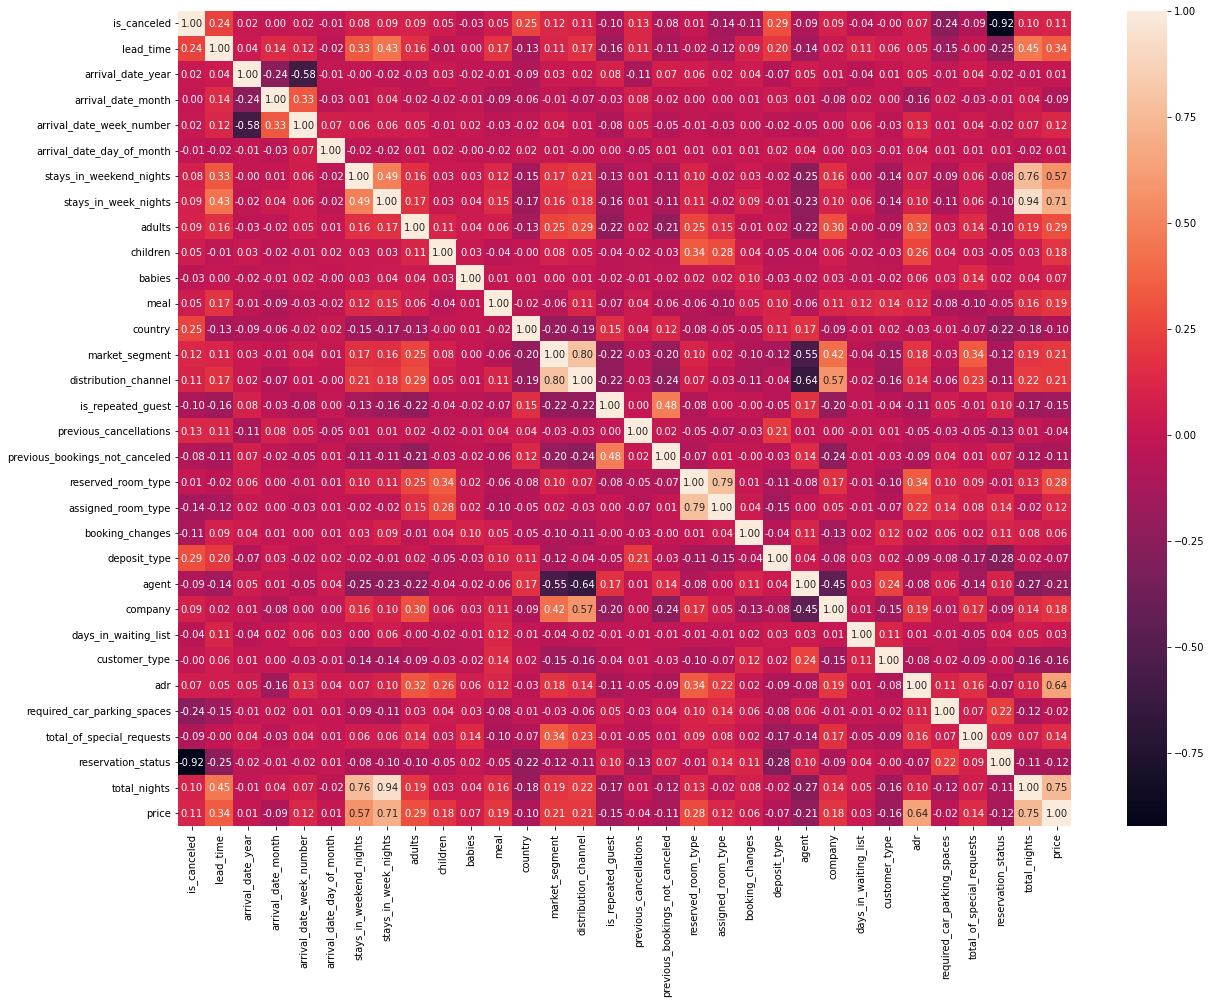

In [7]:
# Correlation

plt.figure(figsize=(20, 15))
sns.heatmap(df_le.corr(), annot=True, fmt='.2f');

In [8]:
# There is high correlation between reservation_status and is_canceled
# There is also a high correlation between total_nights and stays_in_week_nights
# And last one, between total_nights and stays_in_weekend_nights
# So, drop the reservation_status and total_nights
# And drop the reservation_status_date because of related between reservation_status

In [9]:
columns = [
    'reservation_status_date',
    'total_nights',
    'reservation_status',
]

train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)
df_le = df_le.drop(columns, axis=1)

In [10]:
# Dummy variables vs Label Encoder

new_categoricals = [col for col in categoricals if col in train.columns]
df_hot = pd.get_dummies(data=train, columns=new_categoricals)
test_hot = pd.get_dummies(data=test, columns=new_categoricals)

In [11]:
X_hot = df_hot.drop('is_canceled', axis=1)
X_le = df_le.drop('is_canceled', axis=1)
y = train['is_canceled']

In [12]:
# separating it into training and testing set

X_train, X_test, y_train, y_test = train_test_split(X_hot, y, test_size=.2, random_state=42)

log = LogisticRegression().fit(X_train, y_train)
y_pred = log.predict(X_test)

In [13]:
accuracy_score(y_test, y_pred)

0.8232572486119679

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4740
           1       0.80      0.46      0.58      1744

    accuracy                           0.82      6484
   macro avg       0.81      0.71      0.73      6484
weighted avg       0.82      0.82      0.81      6484



In [15]:
# Accuracy score is very good but,
# As we can see, the prediction rate of cancelled bookings is lower
# Therefore, we should increase the cancelled booking samples or decrease the booked booking samples

Feature Elimination

In [16]:
def select(X):
    selects = []
    
    selector = SelectKBest(chi2, k='all').fit(X, y)
    scores = selector.scores_
        
    q3 = np.quantile(scores, 0.75)
    q1 = np.quantile(scores, 0.25)
    iqr = q3 - q1
    threshold = q3 + 1.5 * iqr

    for col, val in zip(X.columns, scores):
        cond1 = val > threshold
        cond2 = col in test_hot.columns or col in test.columns
        
        if cond1 and cond2:
            if col not in test_hot.columns:
                test_hot.loc[:, col] = 0
            selects.append(col)
        
    return selects

In [17]:
selects_hot = select(X_hot)
selects_le = select(X_le)

In [18]:
def compare():
    for is_le in [True, False]:
        method = 'label encoder'
        
        if is_le:
            selected = df_le[selects_le + ['is_canceled']]
        else:
            selected = df_hot[selects_hot + ['is_canceled']]
            method = 'dummy variables'
        
        # separate majority and minority classes
        major = selected[selected['is_canceled'] == 0]
        minor = selected[selected['is_canceled'] == 1]

        # downsample majority class
        downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

        # combine minority class with downsampled majority class
        df_new = pd.concat([downsampled, minor])
    
        X = df_new.drop('is_canceled', axis=1)
        y = df_new['is_canceled']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

        log = LogisticRegression().fit(X_train, y_train)
        y_pred = log.predict(X_test)

        print(f'Accuracy for {method}: {accuracy_score(y_test, y_pred)}')
        print(f'Classification report for {method}:\n{classification_report(y_test, y_pred)}')

In [19]:
compare()

Accuracy for label encoder: 0.6901408450704225
Classification report for label encoder:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1739
           1       0.69      0.69      0.69      1740

    accuracy                           0.69      3479
   macro avg       0.69      0.69      0.69      3479
weighted avg       0.69      0.69      0.69      3479

Accuracy for dummy variables: 0.8002299511353838
Classification report for dummy variables:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1739
           1       0.80      0.80      0.80      1740

    accuracy                           0.80      3479
   macro avg       0.80      0.80      0.80      3479
weighted avg       0.80      0.80      0.80      3479



In [20]:
last = test_hot[selects_hot + ['is_canceled']]

X_last = last.drop('is_canceled', axis=1)
y_last = last['is_canceled']

In [21]:
selected = df_hot[selects_hot + ['is_canceled']]

In [22]:
# separate majority and minority classes
major = selected[selected['is_canceled'] == 0]
minor = selected[selected['is_canceled'] == 1]

# downsample majority class
downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

# combine minority class with downsampled majority class
df_new = pd.concat([downsampled, minor])

# display new class counts
df_new['is_canceled'].value_counts()

0    8697
1    8697
Name: is_canceled, dtype: int64

In [23]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

In [24]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Modelling

In [26]:
# Modelling

class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        if save:
            name = model.__class__.__name__
            plt.savefig(f'/content/{name}_{part}.png')
        plt.show()

In [27]:
report = Report(X_test, y_test)

Logistic Regression

In [28]:
#Logistic Regression

In [29]:
log = LogisticRegression().fit(X_train, y_train)

Accuracy score:

0.8002299511353838

Confusion Matrix:

[[1384  355]
 [ 340 1400]]

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1739
           1       0.80      0.80      0.80      1740

    accuracy                           0.80      3479
   macro avg       0.80      0.80      0.80      3479
weighted avg       0.80      0.80      0.80      3479



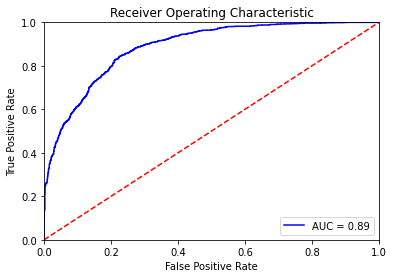

In [30]:
report.metrics(log)
report.plot_roc_curve(log)

In [31]:
cross_val_score(log, X_test, y_test, cv=10).mean()

0.7979297094968366

Naive Bayes

In [32]:
#Naive Bayes

In [33]:
nb = GaussianNB().fit(X_train, y_train)

Accuracy score:

0.7579764300086231

Confusion Matrix:

[[1271  468]
 [ 374 1366]]

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1739
           1       0.74      0.79      0.76      1740

    accuracy                           0.76      3479
   macro avg       0.76      0.76      0.76      3479
weighted avg       0.76      0.76      0.76      3479



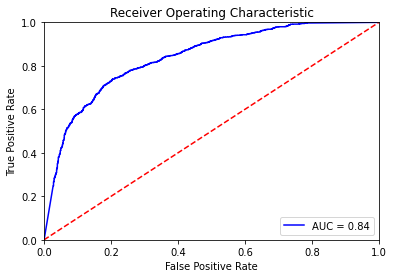

In [34]:
report.metrics(nb)
report.plot_roc_curve(nb)

In [35]:
cross_val_score(nb, X_test, y_test, cv=10).mean()

0.7576940276259565

KNN Classifier

In [36]:
knn = KNeighborsClassifier().fit(X_train, y_train)

Accuracy score:

0.679505605058925

Confusion Matrix:

[[1151  588]
 [ 527 1213]]

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.66      0.67      1739
           1       0.67      0.70      0.69      1740

    accuracy                           0.68      3479
   macro avg       0.68      0.68      0.68      3479
weighted avg       0.68      0.68      0.68      3479



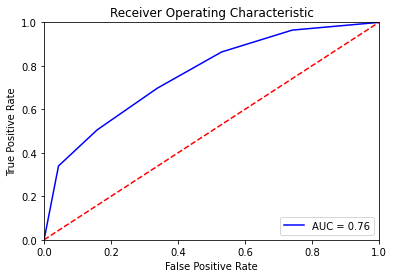

In [37]:
report.metrics(knn)
report.plot_roc_curve(knn)

In [38]:
cross_val_score(knn, X_test, y_test, cv=10).mean()

0.6441352810626388

In [39]:
#Model Tuning

In [40]:
knn_params = {'n_neighbors': range(1, 11)}

In [41]:
params = {
    'estimator': knn,
    'param_grid': knn_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
knn_cv = GridSearchCV(**params)

In [42]:
_ = knn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [43]:
knn_cv.best_params_

{'n_neighbors': 1}

In [44]:
knn = KNeighborsClassifier(**knn_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.7048002299511353

Confusion Matrix:

[[1191  548]
 [ 479 1261]]

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.68      0.70      1739
           1       0.70      0.72      0.71      1740

    accuracy                           0.70      3479
   macro avg       0.71      0.70      0.70      3479
weighted avg       0.71      0.70      0.70      3479



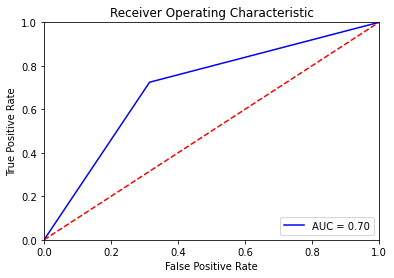

In [45]:
report.metrics(knn)
report.plot_roc_curve(knn)

In [46]:
cross_val_score(knn, X_test, y_test, cv=10).mean()

0.6516148265924674

Decision Tree Classifier

In [47]:
cart = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

Accuracy score:

0.7605633802816901

Confusion Matrix:

[[1101  638]
 [ 195 1545]]

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.63      0.73      1739
           1       0.71      0.89      0.79      1740

    accuracy                           0.76      3479
   macro avg       0.78      0.76      0.76      3479
weighted avg       0.78      0.76      0.76      3479



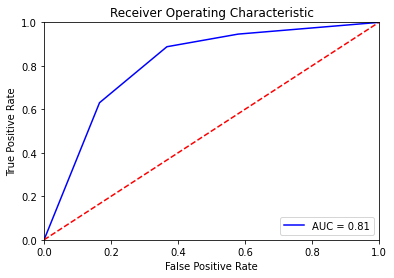

In [48]:
report.metrics(cart)
report.plot_roc_curve(cart)

In [49]:
cross_val_score(cart, X_test, y_test, cv=10).mean()

0.7191700619430919

XGB Boost

Accuracy score:

0.8631790744466801

Confusion Matrix:

[[1427  312]
 [ 164 1576]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1739
           1       0.83      0.91      0.87      1740

    accuracy                           0.86      3479
   macro avg       0.87      0.86      0.86      3479
weighted avg       0.87      0.86      0.86      3479



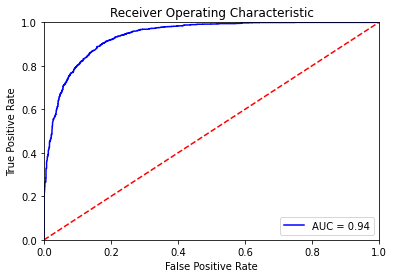

In [50]:
report = Report(X_test, y_test)
xgb = XGBClassifier().fit(X_train, y_train)
report.metrics(xgb)
report.plot_roc_curve(xgb, save=True)

In [51]:
cross_val_score(xgb, X_test, y_test, cv=10).mean()

0.8597245685514592

Gradient Boosting Classifier

Accuracy score:

0.8643288301235987

Confusion Matrix:

[[1434  305]
 [ 167 1573]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1739
           1       0.84      0.90      0.87      1740

    accuracy                           0.86      3479
   macro avg       0.87      0.86      0.86      3479
weighted avg       0.87      0.86      0.86      3479



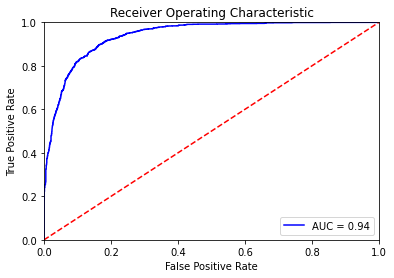

In [52]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster.get_params()

gb = gradient_booster.fit(X_train,y_train)
report.metrics(gb)
report.plot_roc_curve(gb,save=True)

In [53]:
cross_val_score(gb, X_test, y_test, cv=10).mean()

0.8582836463612574